# İçindekiler
1. [Importing Libraries](#1)
2. [EDA](#2)
3. [Logistic Regression](#3)
4. [Random Forest](#4)
5. [XGBoost](#5)
6. [LightGBM](#6)
7. [XGBoost Hyperparameter Tuning](#7)
8. [SMOTE](#8)
9. [Random Forest After SMOTE](#9)
10. [XGBoost After SMOTE](#10)
11. [LightGBM After SMOTE](#11)
12. [XGBoost with Tuned Parameters After SMOTE](#12)

<a id="1"></a><br>
### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
sns.set()
import warnings
warnings.filterwarnings("ignore")

<a id="2"></a><br>
### EDA

In [2]:
df = pd.read_excel("data.xlsx")

In [3]:
df.dropna(inplace=True)
col_names = df.columns.tolist()

In [4]:
col_names

['ilce',
 'il',
 'mahalle',
 'sh',
 'eArsiv',
 'TESISAT',
 'mahalle_egt',
 'mahalle_yas',
 'mahalle_karakteristik',
 'mahalle_populasyon_mesken',
 'mahalle_populasyon_tic',
 'mahalle_tuketim_mesken',
 'mahalle_tuketim_tic',
 'nominal_deger_grubu',
 'banka_otomatik_last_36_ratio',
 'bayi_last_36_ratio',
 'diger_last_36_ratio',
 'enerjisa_vezne_last_36_ratio',
 'web_mobil_last_36_ratio',
 'manuel_tahsilat_36_ratio',
 'na_36_ratio',
 'dbs_last_36_ratio',
 'year',
 'subscriptionLength']

eArsiv
0    356759
1     52105
dtype: int64


<AxesSubplot:xlabel='eArsiv', ylabel='count'>

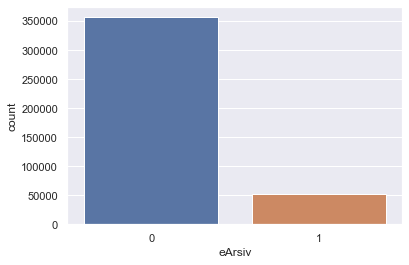

In [5]:
print(df.groupby("eArsiv").size())
sns.countplot(df["eArsiv"], label = "Count")

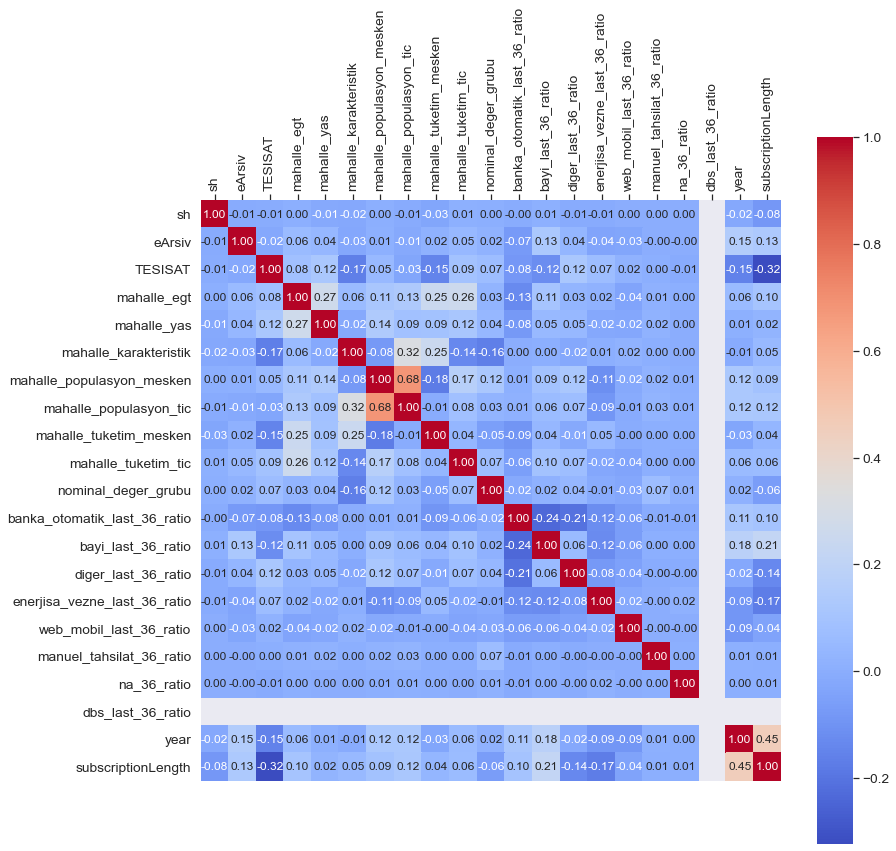

In [6]:
sns.set(font_scale=1.25)
correlation_matrix = df.corr()
plt.figure(figsize = (13,13))
ax = sns.heatmap(correlation_matrix, vmax = 1, cbar = True, square = True, annot = True, fmt = ".2f",
                 annot_kws = {"size": 12}, cmap = "coolwarm")
ax.xaxis.set_ticks_position("top")
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

In [7]:
df.drop(["ilce","il","mahalle","sh","TESISAT"], axis = 1, inplace = True)

<a id="3"></a><br>
### Logistic Regression

In [8]:
y = df["eArsiv"]
X = df.drop(["eArsiv"], axis = 1)
print("X and y: ", X.shape, y.shape)

X and y:  (408864, 18) (408864,)


In [9]:
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [10]:
seed = 40
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30, random_state = seed, stratify = y)
print("Training and test sizes: ", len(X_train), len(X_test))

Training and test sizes:  286204 122660


In [11]:
scalerX = StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

In [12]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_grid = {"C": C_values}

# cross validation
kfold = StratifiedKFold(n_splits = 10, random_state = 0)

Clf = LogisticRegression(penalty = "l1", random_state = seed, solver = "liblinear")
grid_logReg = GridSearchCV(Clf, C_grid, cv = kfold)
grid_logReg.fit(X_train, y_train)
print("Optimum C (1/lambda):", grid_logReg.best_estimator_.C)

Optimum C (1/lambda): 0.001


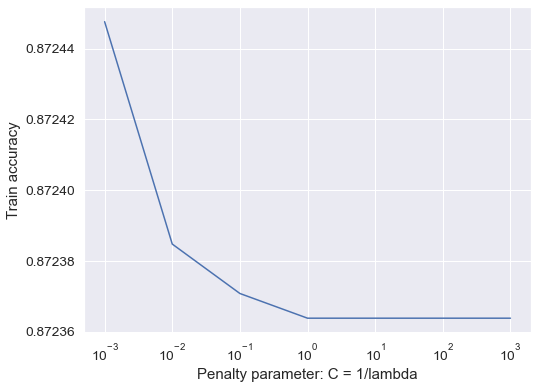

In [13]:
# C değeri 0.001 geldi
plt.figure(figsize=(8,6))
plt.semilogx(C_values, grid_logReg.cv_results_["mean_test_score"])
plt.xlabel("Penalty parameter: C = 1/lambda")
plt.ylabel("Train accuracy")
plt.show()

In [14]:
Clf = LogisticRegression(penalty = "l1", C = 0.001, random_state = seed, solver = "liblinear")
Clf.fit(X_train, y_train)
predictions = Clf.predict(X_test)
print("Training accuracy: ", (accuracy_score(y_train, Clf.predict(X_train))))
print( 'Classification accuracy :',(accuracy_score(y_test, predictions)) ,"\n")

Training accuracy:  0.8724546127936716
Classification accuracy : 0.872427849339638 



In [15]:
# training accuracy %87
# classification / test accuracy %87
# bir takım plotlar
def evalBinaryClassifier(model, x, y, labels = ["Positives", "Negatives"]):
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError("A binary class problem is required")
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
        
    plt.figure(figsize = (15,4))
    cm = confusion_matrix(y, model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot = True, cmap = "Blues", cbar = False, annot_kws = {"size": 14}, fmt = "g")
    cmlabels = ["True Negatives", "False Positives", "False Negatives", "True Positives"]
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title("Confusion Matrix", size = 15)
    plt.xlabel("Predicted Values", size = 13)
    plt.ylabel("True Values", size = 13)
    
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target == 1].probPos, density = True, alpha = .5, color = "green", label = labels[0])
    plt.hist(df[df.target == 0].probPos, density = True, alpha = .5, color = "red", label = labels[1])
    plt.axvline(.5, color = "blue", linestyle = "--", label = "Boundary")
    plt.xlim([0,1])
    plt.title("Distributions of Predictions", size = 15)
    plt.xlabel("Positive Probability (predicted)", size = 13)
    plt.ylabel("Samples (normalized scale)", size = 13)
    plt.legend(loc = "upper right")
    
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color = "green", lw = 1, label = "ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], lw = 1, linestyle = "--", color = "grey")
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp / (fp+tn), tp / (tp+fn), "bo", markersize = 8, label = "Decision Point")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", size = 13)
    plt.ylabel("True Positive Rate", size = 13)
    plt.title("ROC Curve", size = 15)
    plt.legend(loc = "lower right")
    plt.subplots_adjust(wspace = .3)
    plt.show()
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

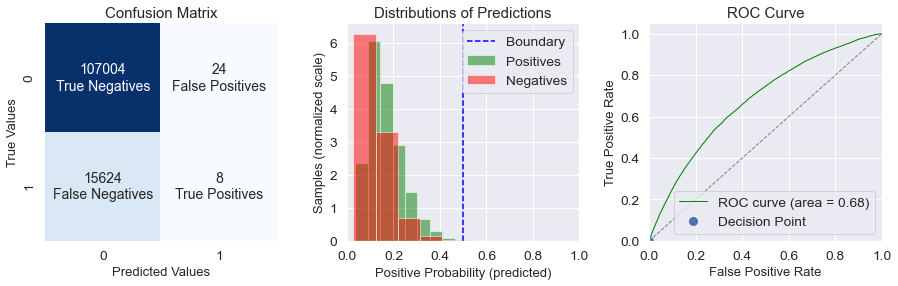

Precision: 0.25 | Recall: 0.0 | F1 Score: 0.0 | 


In [16]:
F1 = evalBinaryClassifier(Clf, X_test, y_test)

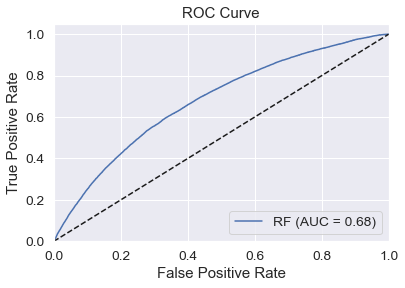

In [17]:
fpr, tpr, _ = roc_curve(y_test, Clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = "RF (AUC = %0.2f)" % roc_auc)

plt.plot([0,1], [0,1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
def draw_cm(actual, predicted):
    cm = confusion_matrix(actual, predicted, [1,0])
    sns.heatmap(cm, annot = True, fmt = ".0f", xticklabels = ["1", "0"], yticklabels = ["1", "0"])
    plt.ylabel("ACTUAL")
    plt.xlabel("PREDICTED")
    plt.show()

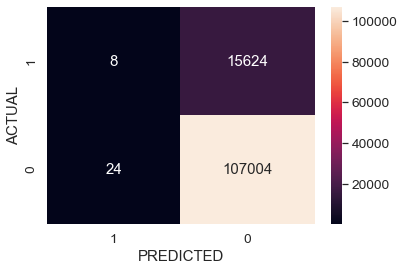

In [19]:
draw_cm(y_test, predictions)

Cutoff  Cost/Customer(TL)  Accuracy  FN    FP    TP    TN   Recall  Precision
0.00   100.00              0.127      0   107028   15632     0   1.000   0.127
0.05    97.94              0.149     56   104276   15576   2752   0.996   0.130
0.10    71.10              0.501    3463   57723   12169   49305   0.778   0.174
0.16    60.06              0.729    8266   24972   7366   82056   0.471   0.228
0.21    59.68              0.818    11751   10562   3881   96466   0.248   0.269
0.26    61.42              0.852    13842   4338   1790   102690   0.115   0.292
0.31    62.56              0.865    14849   1713   783   105315   0.050   0.314
0.36    63.33              0.870    15352   643   280   106385   0.018   0.303
0.42    63.59              0.872    15546   188    86   106840   0.006   0.314
0.47    63.70              0.872    15612    55    20   106973   0.001   0.267
0.52    63.71              0.873    15625    12     7   107016   0.000   0.368
0.57    63.72              0.873    15632   

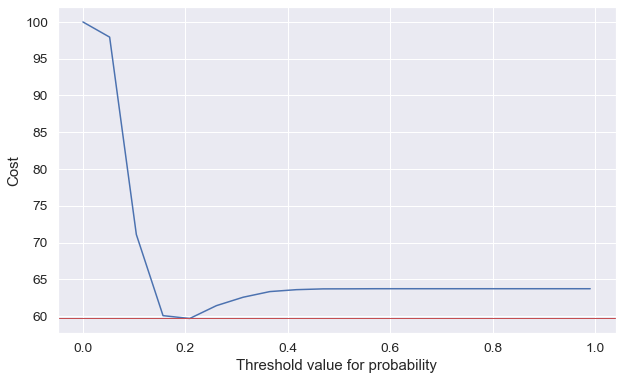

In [20]:
from sklearn.preprocessing import binarize
from sklearn.metrics import precision_score, recall_score

def costfunc(Z):
    TP = Z[1,1] ; TN = Z[0,0] ; FP = Z[0,1] ; FN = Z[1,0]
    cost = 500.*FN + 0.*TN + 100.*FP + 100.*TP
    return cost

y_pred_prob = Clf.predict_proba(X_test)
Xp = [] ; Yp = []
print("Cutoff  Cost/Customer(TL)  Accuracy  FN    FP    TP    TN   Recall  Precision")
for cutoff in np.linspace(0., 0.99, 20):
    y_pred_class = binarize(y_pred_prob, cutoff)[:,1]
    cm = confusion_matrix(y_test, y_pred_class)
    cost_per = costfunc(cm)/len(y_test)
    Xp.append(cutoff)
    Yp.append(cost_per)
    print( '%4.2f   %6.2f              %5.3f    %3d   %3d   %3d   %3d   %5.3f   %5.3f' % 
          (cutoff, cost_per, accuracy_score(y_test, y_pred_class),
           cm[1,0], cm[0,1], cm[1,1], cm[0,0], cm[1,1]/(cm[1,1]+cm[1,0]), cm[1,1]/(cm[1,1]+cm[0,1])))
    
plt.figure(figsize = (10,6))
plt.plot(Xp, Yp)
plt.xlabel("Threshold value for probability")
plt.ylabel("Cost")
plt.axhline(y = min(Yp), xmin = 0., xmax = 1., linewidth = 1, color = "r")
plt.show()

<a id="4"></a><br>
### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier as RF
Clf = RF(random_state = seed)
kfold = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
cv_results = model_selection.cross_val_score(Clf, X_train, y_train, cv = kfold, scoring = "accuracy")
Clf.fit(X_train, y_train)
predictions = Clf.predict(X_test)
print("Training accuracy: ", accuracy_score(y_train, Clf.predict(X_train)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))

Training accuracy:  0.999818311414236
Classification accuracy:  0.880621229414642


<a id="5"></a><br>
### XGBoost

In [22]:
from xgboost import XGBClassifier
Clf = XGBClassifier(random_state = seed)
cv_results = model_selection.cross_val_score(Clf, X_train, y_train, cv = kfold, scoring = "accuracy")
Clf.fit(X_train, y_train)
predictions = Clf.predict(X_test)
print("Training accuracy: ", accuracy_score(y_train, Clf.predict(X_train)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))

Training accuracy:  0.8781323810987967
Classification accuracy:  0.8759497798793413


<a id="6"></a><br>
### LightGBM

In [23]:
import lightgbm as lgb
Clf = lgb.LGBMClassifier(random_state = seed)
cv_results = model_selection.cross_val_score(Clf, X_train, y_train, cv = kfold, scoring = "accuracy")
Clf.fit(X_train, y_train)
predictions = Clf.predict(X_test)
print("Training accuracy: ", accuracy_score(y_train, Clf.predict(X_train)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))

Training accuracy:  0.8755572947967184
Classification accuracy:  0.8754850807109082


<a id="7"></a><br>
### XGBoost Hyperparameter Tuning

In [148]:
from sklearn.model_selection import RandomizedSearchCV

In [258]:
param_grid = {
    "max_depth": [40, 60, 80, 100],
    "learning_rate": [0,1,0.2,0.3],
    "n_estimators": [60,70,80,90,100,120]
}

In [259]:
Clf = XGBClassifier(random_state = seed)

In [260]:
grid_search = RandomizedSearchCV(Clf, param_grid, cv = 2, scoring = "accuracy", n_iter = 20)

In [261]:
grid_result = grid_search.fit(X_train, y_train)

In [262]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.876522 using {'n_estimators': 80, 'max_depth': 100, 'learning_rate': 0.2}


In [269]:
best = grid_result.best_params_
xgboost = XGBClassifier(n_estimators = 90, max_depth = 40, learning_rate = 0.2, random_state = seed)
xgb_tuned =  xgboost.fit(X_train,y_train)

In [270]:
predictions = xgboost.predict(X_test)

In [271]:
print("Training accuracy: ", accuracy_score(y_train, xgboost.predict(X_train)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))

Training accuracy:  0.994332713728669
Classification accuracy:  0.8826838415131257


<a id="8"></a><br>
### SMOTE

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
def evaluate_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, scoring="accuracy")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    draw_cm(y_test, preds)

In [26]:
Clf = LogisticRegression(penalty = "l1", C = 0.001, random_state = seed, solver = "liblinear")

Training Score:0.8724546127936716
Cross V Score: 0.8724930465817341 +/- 4.853461459399416e-05
Testing Score: 0.872427849339638
Cross & Test Diff: 6.519724209608224e-05
Standard Deviations Away: 1.343314305500841


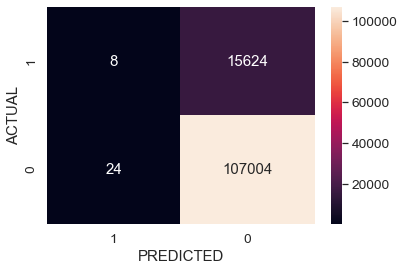

In [27]:
evaluate_model(X_train, y_train, Clf)

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
smt = SMOTE(random_state=seed)
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

Training Score:0.6334616046866428
Cross V Score: 0.6334896312465623 +/- 0.0007734718356533052
Testing Score: 0.6415457361813142
Cross & Test Diff: -0.00805610493475184
Standard Deviations Away: -10.415511675285929


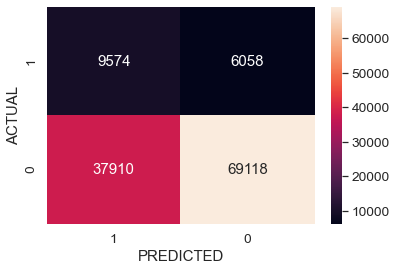

In [30]:
evaluate_model(X_train_SMOTE, y_train_SMOTE, Clf)

In [37]:
from sklearn.metrics import f1_score

<a id="9"></a><br>
### Random Forest After SMOTE

In [38]:
Clf = RF(random_state = seed)
kfold = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
cv_results = model_selection.cross_val_score(Clf, X_train_SMOTE, y_train_SMOTE, cv = kfold, scoring = "accuracy")
Clf.fit(X_train_SMOTE, y_train_SMOTE)
predictions = Clf.predict(X_test)
print("Training accuracy: ", accuracy_score(y_train_SMOTE, Clf.predict(X_train_SMOTE)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))
score = f1_score(y_test, predictions)
print("F1 Score: ", score)

Training accuracy:  0.9999259202902323
Classification accuracy:  0.8135741072884396
F1 Score:  0.3199809676747851


<a id="10"></a><br>
### XGBoost After SMOTE

In [39]:
Clf = XGBClassifier(random_state = seed)
cv_results = model_selection.cross_val_score(Clf, X_train_SMOTE, y_train_SMOTE, cv = kfold, scoring = "accuracy")
Clf.fit(X_train_SMOTE, y_train_SMOTE)
predictions = Clf.predict(X_test)
print("Training accuracy: ", accuracy_score(y_train_SMOTE, Clf.predict(X_train_SMOTE)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))
score = f1_score(y_test, predictions)
print("F1 Score: ", score)

Training accuracy:  0.8073787395237275
Classification accuracy:  0.7852763737159628
F1 Score:  0.30842348492805377


<a id="11"></a><br>
### LightGBM After SMOTE

In [40]:
Clf = lgb.LGBMClassifier(random_state = seed)
cv_results = model_selection.cross_val_score(Clf, X_train_SMOTE, y_train_SMOTE, cv = kfold, scoring = "accuracy")
Clf.fit(X_train_SMOTE, y_train_SMOTE)
predictions = Clf.predict(X_test)
print("Training accuracy: ", accuracy_score(y_train_SMOTE, Clf.predict(X_train_SMOTE)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))
score = f1_score(y_test, predictions)
print("F1 Score: ", score)

Training accuracy:  0.7630069955271872
Classification accuracy:  0.7563264307842817
F1 Score:  0.3230584558240663


<a id="12"></a><br>
### XGBoost with Tuned Parameters After SMOTE

In [41]:
xgboost = XGBClassifier(n_estimators = 90, max_depth = 40, learning_rate = 0.2, random_state = seed)
xgb_tuned =  xgboost.fit(X_train,y_train)
predictions = xgboost.predict(X_test)
print("Training accuracy: ", accuracy_score(y_train, xgboost.predict(X_train)))
print("Classification accuracy: ", accuracy_score(y_test, predictions))
score = f1_score(y_test, predictions)
print("F1 Score: ", score)

Training accuracy:  0.994332713728669
Classification accuracy:  0.8826838415131257
F1 Score:  0.2802840852255677
